Train an LSTM on small data, trainable in a notebook, to experiment with the architecture and optimizer parameters. The goal is to overfit on small data to make sure the model is complex enough, and then look at what model generated sequences sound like (e.g. how similar to the training data do they sound?).

In [218]:
from pathlib import Path
import torch
import torch.nn as nn
import numpy as np
from torch.nn.functional import softplus, log_softmax, softmax
from torch.utils.data import DataLoader, random_split
import music21 as m21
from torch import optim
import pandas as pd

path_to_musescore = "/Applications/MuseScore 4.app/Contents/MacOS/mscore"
m21.environment.UserSettings()["musicxmlPath"] = path_to_musescore
m21.environment.UserSettings()["musescoreDirectPNGPath"] = path_to_musescore

TOKENS = {"rest": "R", "hold": "H", "end": "E"}


class MelodyLSTM(nn.Module):
    __version__ = "0.0.1"

    def __init__(self, output_size: int, embedding_size: int, hidden_size: int):
        """LSTM model for melody generation

        A song is a sequence of notes. A note is represented as a pitch or rest or hold token.

        Args:
            output_size: Number of unique tokens (vocabulary size), i.e., pitch range + 2.
            embedding_size: Pitch embedding dimension.
            hidden_size: Hidden LSTM dimension.
        """
        super().__init__()
        self.output_size = output_size
        self.embedding_size = embedding_size
        self.hidden_size = hidden_size

        # The embedding is useful because the pitch space is sparse.
        # (batch_size, seq_len) -> (batch_size, seq_len, embedding_size)
        self.embedding = nn.Embedding(output_size, embedding_size)
        # (batch_size, seq_len, embedding_size) -> (batch_size, seq_len, hidden_size)
        self.lstm = nn.LSTM(embedding_size, hidden_size, batch_first=True)
        # (batch_size, seq_len, hidden_size) -> (batch_size, seq_len, output_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, note_seq: torch.Tensor | np.ndarray | list) -> torch.Tensor:
        """Forward pass

        Args:
            note_seq: torch tensor of shape (batch_size, seq_len) and dtype float32.
            If note_seq is a list or numpy array it is cast into a torch tensor.

        Returns:
            Log-probabilities as torch tensor of shape (batch_size, seq_len, output_size)
        """
        if isinstance(note_seq, np.ndarray) or isinstance(note_seq, list):
            batch_size = len(note_seq)
            note_seq = torch.tensor(note_seq, dtype=torch.int)
            note_seq = note_seq.reshape(batch_size, -1)
        note_seq = torch.atleast_2d(note_seq)
        embeds = self.embedding(note_seq)
        lstm_out, _ = self.lstm(embeds)
        out = self.fc(lstm_out)
        scores = log_softmax(out, dim=2)  # log_softmax(z) = z - log(sum(exp(z)))
        return scores


class TimeSeriesDataset(torch.utils.data.Dataset):

    def __init__(
        self,
        path: str | Path,
        sequence_length: int,
        transform: callable = None,
        size: int = None,
    ):
        """Time series dataset of notes

        Args:
            path: Path to a text file or a directory of text files. The text file is a sequence of tokens, see :func:`read_time_series`.
            sequence_length: Sequence length to use as input for predicting the next item in the sequence.
            transform: A function (list[str] -> iterable of any) applied to sequences.
            size: Number of data items, i.e., dataset length (number of tokens - sequence length). If None, uses all data in `path`. Else reads the first `size` sequence items from files in `path` (files are read in Path.glob()'s order).
        """
        self.sequence_length = sequence_length
        self.transform = transform
        self.path = Path(path)
        if self.path.is_file():
            self.files = [self.path]
        else:
            self.files = list(self.path.glob("*.txt"))
        data: list[str] = []
        for file in self.files:
            songs = read_time_series(file)
            for song in songs:
                data.extend(song)
            if size is not None:
                if len(data) - self.sequence_length >= size:
                    data = data[: size + self.sequence_length]
                    break
        if self.transform is not None:
            data = self.transform(data)
        self.data = data

    def __getitem__(self, idx):
        """Get item

        Args:
            idx: Index.

        Returns:
            sequence: iterable of `self.sequence_length` tokens (type determined by self.transform).
            If self.transform is None, `sequence` is a list of strings.
            next_item: next token to predict
        """
        idx1 = idx + self.sequence_length
        return self.data[idx:idx1], self.data[idx1]

    def __len__(self):
        return len(self.data) - self.sequence_length


def read_time_series(
    file: str | Path,
    song_delim: str = "\n",
    beat_delim: str = " ",
    note_delim: str = ",",
) -> list[list[str | tuple]]:
    """Read songs in a time-series representation from a text file

    - The file contains songs. Songs are separated by `song_delim`.
    - A song is a sequence of beats. Beats are separated by `beat_delim`.
    - A beat is a string token: a pitch, a tuple of pitches (separated by `note_delim`) or a non-pitch token (like rest or hold).

    Examples:

    - "62 64 65" -> ["62", "64", "65"]
    - "62 64 65\n40 40,44 50" -> ["62", "64", "65"], ["40", ("40", "44"), "50"]

    Args:
        file: Path to a text file.
        song_delim: Song deliminator.
        beat_delim: Beat deliminator.
        note_delim: Note deliminator.

    Returns:
        songs in a time series format
    """
    with open(file) as f:
        raw: str = f.read()
    return [
        [
            beat if beat.find(note_delim) == -1 else tuple(beat.split(note_delim))
            for beat in song.split(beat_delim)
        ]
        for song in raw.split(song_delim)
        if song != ""
    ]


def train(
    model: MelodyLSTM,
    train_loader: DataLoader,
    validation_loader: DataLoader,
    loss_fn: callable,
    optimizer: torch.optim.Optimizer,
    num_epochs: int = 1,
    device: torch.device = torch.device("cpu"),
) -> tuple[float, float]:
    for epoch in range(1, num_epochs + 1):
        print(f"Epoch {epoch}")
        model.train()
        progress_step = 1000  # Print and log every `progress_step` batch.
        for batch, (inputs, target) in enumerate(train_loader, start=1):
            model.zero_grad()
            inputs = inputs.to(device)  # (batch_size, sequence_length)
            target = target.to(device)  # (batch_size,)
            output = model(inputs)  # (batch_size, sequence_length, output_size)

            loss_batch = loss_fn(output[:, -1], target)
            loss_batch.backward()
            if batch == 1 or (batch % progress_step) == 0:
                print(f"batch {batch}. " f"loss_batch = {loss_batch.item():.4E}. ")
            optimizer.step()

        loss_tr = validate_epoch(model, loss_fn, train_loader, device=device)
        loss_va = validate_epoch(model, loss_fn, validation_loader, device=device)
        print(f"loss_va = {loss_va:.4f}")
        print(f"loss_tr = {loss_tr:.4f}")
    return loss_tr, loss_va


@torch.no_grad()
def validate_epoch(
    model: MelodyLSTM,
    loss_fn: callable,
    validation_loader: DataLoader,
    device: torch.device = torch.device("cpu"),
) -> float:
    """Compute the average validation loss

    Args:
        model: Torch model (nn.Module).
        loss_fn: Loss function.
        validation_loader: Torch DataLoader for validation data.
        device: Torch device. Defaults to torch.device("cpu").

    Returns:
        average loss on the validation data
    """
    model.eval()
    loss_sum = 0
    num_instances = 0
    with torch.no_grad():
        for _, (inputs, target) in enumerate(validation_loader, start=1):
            inputs = inputs.to(device)
            target = target.to(device)
            output = model(inputs)

            batch_size, sequence_length = inputs.shape
            num_instances += batch_size
            loss_batch = loss_fn(output[:, -1], target)
            loss_sum += loss_batch * batch_size
    return loss_sum.item() / num_instances


def make_data_loaders(
    data: torch.utils.data.Dataset,
    batch_size: int,
    pct_tr: float,
    seed_split: int = None,
    seed_loader: int = None,
) -> tuple[DataLoader, DataLoader]:
    """Make train and validation data loaders

    Args:
        data: Torch dataset.
        batch_size: Batch size.
        pct_tr: Percent of data for training set.
        seed_split: Random seed for splitting to train-validation. Defaults to None.
        seed_loader: Random seed for train loader. Defaults to None.

    Returns:
        tuple of torch DataLoaders
    """
    batch_size_validation = 10000
    data_tr, data_va = random_split(
        data,
        lengths=(pct_tr, 1 - pct_tr),
        generator=torch.Generator().manual_seed(seed_split),
    )
    train_loader = DataLoader(
        data_tr,
        batch_size=batch_size,
        shuffle=True,
        generator=torch.Generator().manual_seed(seed_loader),
    )
    validation_loader = DataLoader(
        data_va, batch_size=batch_size_validation, shuffle=False
    )
    return train_loader, validation_loader


def time_series_to_midi(
    sequence: list[str],
    step_duration: float,
    filename: str | Path = None,
    hold_token=TOKENS["hold"],
    rest_token=TOKENS["rest"],
    end_token=TOKENS["end"],
):
    """Convert a time series melody to midi

    Args:
        sequence: list of strings. A melody as notes or rests or hold tokens at fixed time steps.
        filename: Path to save midi file. Defaults to None.

    Returns:
        music21 stream
    """

    def make_note(pitch, length):
        return (
            m21.note.Rest(quarterLength=length)
            if pitch is None
            else m21.note.Note(midi=pitch, quarterLength=length)
        )

    stream = m21.stream.Stream()
    step = 1
    pitch_prev = None
    for i, e in enumerate(sequence):
        if e == hold_token:
            step += 1
            continue
        if e == end_token:
            break
        if i > 0:
            stream.append(make_note(pitch_prev, step_duration * step))
        step = 1
        pitch_prev = None if e == rest_token else int(e)
    stream.append(make_note(pitch_prev, step_duration * step))

    if filename is not None:
        stream.write(fmt="midi", fp=filename)
    return stream


def generate_melody(
    model: MelodyLSTM,
    initial_sequence: list[int],
    num_notes: int,
    sequence_length: int,
    temperature: float = 1.0,
    random_seed: int = None,
    allowed_notes: list[int] = None,
) -> list[int]:
    """Generate a melody

    Args:
        model: A MelodyLSTM model.
        initial_sequence: A list of encoded note tokens to start the melody.
        num_notes: Number of tokens to generate.
        sequence_length: The number of tokens to use as context in the model.
        temperature: Temperature parameter for sampling. Defaults to 1.0.
        random_seed: Random seed. Defaults to None.
        allowed_notes: Notes that can be sampled. For example, to not sample notes not seen during training.

    Returns:
        a melody that starts with `initial_sequence` and continues for `num_notes` tokens
    """
    rng = torch.default_generator
    if random_seed is not None:
        rng = rng.manual_seed(random_seed)
    melody = list(initial_sequence)
    for _ in range(num_notes):
        inputs = melody[-sequence_length:]
        output = model([inputs])[:, -1].ravel().detach()  # log_softmax(.)
        if allowed_notes is not None:
            out = torch.full_like(output, -torch.inf)
            out[allowed_notes] = output[allowed_notes]
            output = out
        next_item = sample_with_temperature(
            output.ravel(), t=temperature, rng=rng, logp=True
        )
        melody.append(next_item)
    return melody


def sample_with_temperature(
    scores: torch.tensor,
    t: float = 1.0,
    rng: torch.Generator = torch.default_generator,
    logp: bool = True,
) -> int:
    """Sample with temperature

    Sample from a discrete probability distribution with some randomness, given by a temperature.

    Args:
        scores: Softmax scores for C classes as a tensor of shape (C,).
        t: Temperature. Defaults to 1.0.
        rng: torch random number Generator.
        logp: If True, scores are log-softmax.

    Returns:
        an integer in [0, C-1]
    """
    logscores = np.log(scores) if not logp else scores
    prob = softmax(logscores / t, dim=0)
    return torch.multinomial(prob, 1, generator=rng).item()


def show_midi(notes, fmt="midi"):
    time_series_to_midi(notes, step_duration=0.25).show(fmt=fmt)

In [ ]:
path_to_jsb = "../data/jsb_chorales.txt"
encoding = {
    token: i
    for i, token in enumerate(
        "36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 E R".split(
            " "
        )
    )
}
decoding = {v: k for k, v in encoding.items()}
encode = lambda seq: torch.tensor([encoding[e] for e in seq])
decode = lambda seq: [decoding[e] for e in seq]

DEVICE = "mps"
LEARNING_RATE = 0.01
STEP_SIZE = 0.25
EMBEDDING_SIZE = 32
HIDDEN_SIZE = 256
OUTPUT_SIZE = len(encoding)
BATCH_SIZE = 10
SEQUENCE_LENGTH = 4 * 4 * 4

# Data

Use a tiny subset of the `jsb_chorales` data.

In [226]:
data = TimeSeriesDataset(
    path=path_to_jsb,
    sequence_length=SEQUENCE_LENGTH,
    transform=encode,
    size=10,
)

train_loader, validation_loader = make_data_loaders(
    data, batch_size=BATCH_SIZE, seed_loader=0, seed_split=0, pct_tr=0.7
)
print(
    f"The data are {len(data)} (tr={len(train_loader.dataset)},va={len(validation_loader.dataset)}) input-output pairs from {len(data.data)} notes with {data.sequence_length} context: "
)

data.data

The data are 10 (tr=7,va=3) input-output pairs from 74 notes with 64 context: 


tensor([29, 29, 29, 29, 36, 36, 34, 34, 33, 33, 31, 31, 29, 29, 29, 29, 36, 36,
        36, 36, 38, 38, 38, 38, 38, 38, 38, 38, 36, 36, 36, 36, 36, 36, 36, 36,
        38, 38, 38, 38, 40, 40, 40, 40, 41, 41, 41, 41, 40, 40, 40, 40, 38, 38,
        38, 38, 38, 38, 38, 38, 36, 36, 36, 36, 33, 33, 33, 33, 38, 38, 38, 38,
        36, 36])

Below is the whole dataset (train and validation).

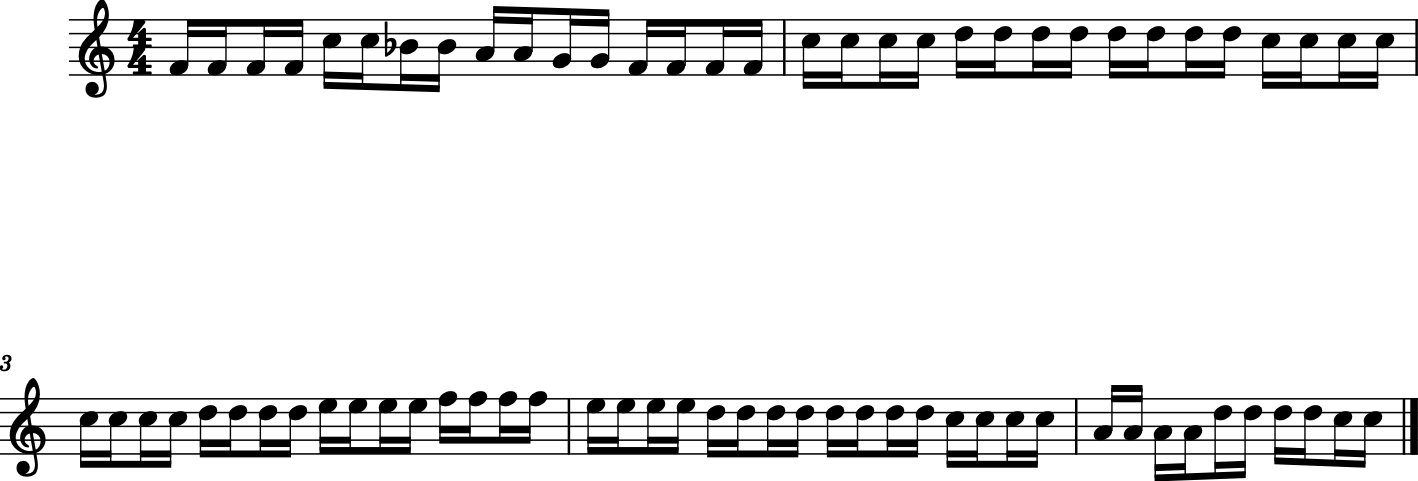

In [52]:
show_midi(decode(data.data.tolist()), fmt=None)
show_midi(decode(data.data.tolist()))

# Train small model

In [5]:
model = MelodyLSTM(
    output_size=OUTPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
).to(DEVICE)
loss_fn = nn.NLLLoss()  # Input: log probabilities
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

In [ ]:
train(
    model=model,
    train_loader=train_loader,
    validation_loader=validation_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    num_epochs=2000,
    device=DEVICE,
)

Below is a sequence generated by predicting the next note with the model.

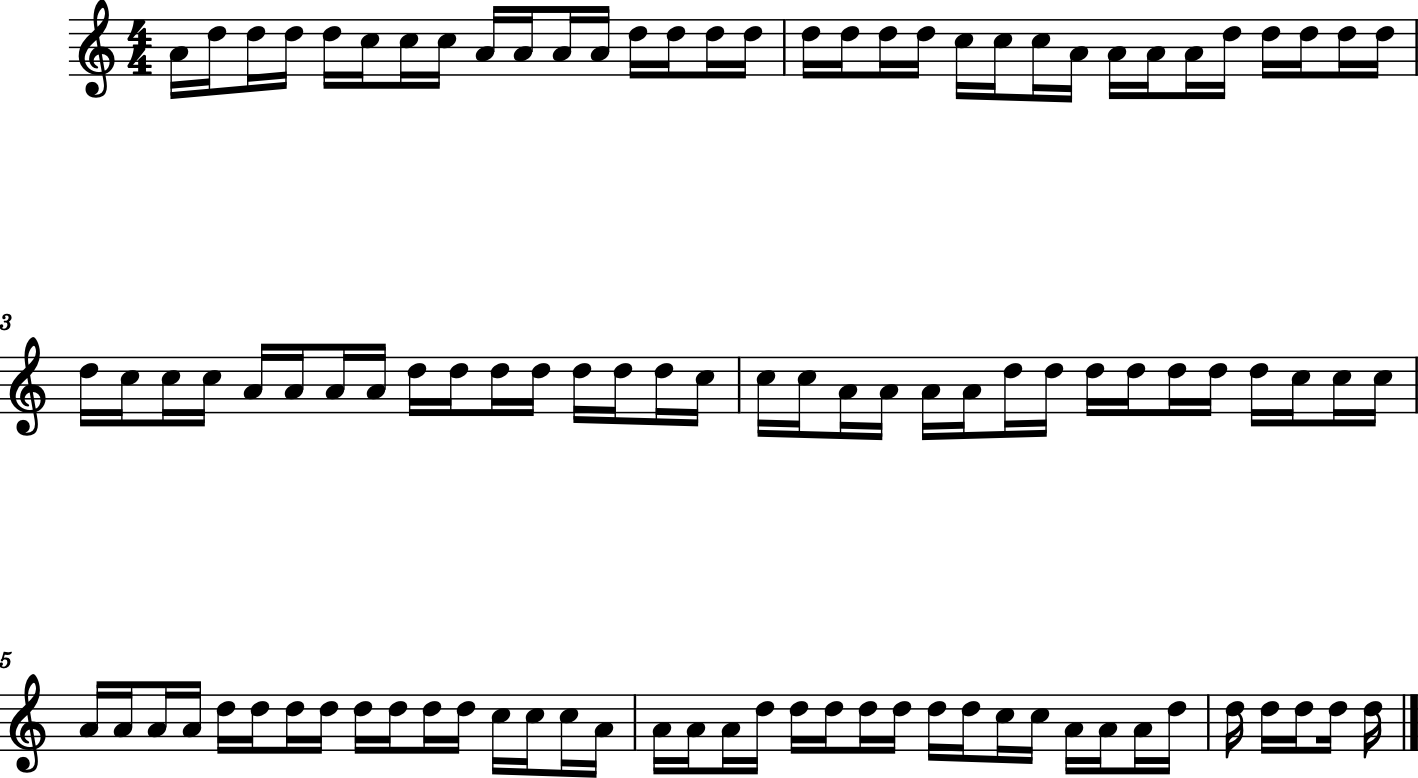

In [ ]:
melody = generate_melody(
    model=model.to("cpu"),
    initial_sequence=[33],
    num_notes=100,
    sequence_length=SEQUENCE_LENGTH,
    temperature=0.6,
    random_seed=1,
    allowed_notes=[v for k, v in encoding.items() if k not in TOKENS.values()],
)


show_midi(decode(melody), fmt=None)
show_midi(decode(melody))

## Interpreting the loss

It is not clear how to think about an average loss value like 0.01 and what it means about the quality of generated sequences. Sequences are generated by repeatedly predicting the next element. 

The optimized loss `NLLLoss` is (minus) the prediction for the correct next element in the sequence. In pytorch it expects log-probabilities as input, so it is simply `NLLLoss(lp, y) = -lp[y]`, or $l(\log \hat{\mathbf{p}}, y) = -\log \hat{p}_y$. The NLL loss is about the average *confidence* the network has for the actual next note in the sequence, not an accuracy of a predicted note.

Below are all the (sequence, next element) pairs in the data with their NLL losses and the predicted probability for the true next note.

In [ ]:
model = model.to("cpu")
losses = [
    loss_fn(
        model(inputs)[:, -1],
        target.reshape(-1),
    ).item()
    for inputs, target in data
]
pd.DataFrame(
    {
        "sequence": [" ".join(map(str, inputs.tolist())) for inputs, target in data],
        "next note": [target.item() for inputs, target in data],
        "loss": losses,
        "P(next note)": 1 / np.exp(losses),
    }
).style.set_properties(subset=["sequence"], **{"width": "300px"})

,sequence,next note,loss,P(next note)
0,29 29 29 29 36 36 34 34 33 33 31 31 29 29 29 29 36 36 36 36 38 38 38 38 38 38 38 38 36 36 36 36 36 36 36 36 38 38 38 38 40 40 40 40 41 41 41 41 40 40 40 40 38 38 38 38 38 38 38 38 36 36 36 36,33,0.003222,0.996783
1,29 29 29 36 36 34 34 33 33 31 31 29 29 29 29 36 36 36 36 38 38 38 38 38 38 38 38 36 36 36 36 36 36 36 36 38 38 38 38 40 40 40 40 41 41 41 41 40 40 40 40 38 38 38 38 38 38 38 38 36 36 36 36 33,33,0.000223,0.999777
2,29 29 36 36 34 34 33 33 31 31 29 29 29 29 36 36 36 36 38 38 38 38 38 38 38 38 36 36 36 36 36 36 36 36 38 38 38 38 40 40 40 40 41 41 41 41 40 40 40 40 38 38 38 38 38 38 38 38 36 36 36 36 33 33,33,0.000367,0.999633
3,29 36 36 34 34 33 33 31 31 29 29 29 29 36 36 36 36 38 38 38 38 38 38 38 38 36 36 36 36 36 36 36 36 38 38 38 38 40 40 40 40 41 41 41 41 40 40 40 40 38 38 38 38 38 38 38 38 36 36 36 36 33 33 33,33,0.036298,0.964353
4,36 36 34 34 33 33 31 31 29 29 29 29 36 36 36 36 38 38 38 38 38 38 38 38 36 36 36 36 36 36 36 36 38 38 38 38 40 40 40 40 41 41 41 41 40 40 40 40 38 38 38 38 38 38 38 38 36 36 36 36 33 33 33 33,38,0.035007,0.965599
5,36 34 34 33 33 31 31 29 29 29 29 36 36 36 36 38 38 38 38 38 38 38 38 36 36 36 36 36 36 36 36 38 38 38 38 40 40 40 40 41 41 41 41 40 40 40 40 38 38 38 38 38 38 38 38 36 36 36 36 33 33 33 33 38,38,0.000639,0.999361
6,34 34 33 33 31 31 29 29 29 29 36 36 36 36 38 38 38 38 38 38 38 38 36 36 36 36 36 36 36 36 38 38 38 38 40 40 40 40 41 41 41 41 40 40 40 40 38 38 38 38 38 38 38 38 36 36 36 36 33 33 33 33 38 38,38,0.001679,0.998322
7,34 33 33 31 31 29 29 29 29 36 36 36 36 38 38 38 38 38 38 38 38 36 36 36 36 36 36 36 36 38 38 38 38 40 40 40 40 41 41 41 41 40 40 40 40 38 38 38 38 38 38 38 38 36 36 36 36 33 33 33 33 38 38 38,38,0.008655,0.991383
8,33 33 31 31 29 29 29 29 36 36 36 36 38 38 38 38 38 38 38 38 36 36 36 36 36 36 36 36 38 38 38 38 40 40 40 40 41 41 41 41 40 40 40 40 38 38 38 38 38 38 38 38 36 36 36 36 33 33 33 33 38 38 38 38,36,3.232233,0.039469
9,33 31 31 29 29 29 29 36 36 36 36 38 38 38 38 38 38 38 38 36 36 36 36 36 36 36 36 38 38 38 38 40 40 40 40 41 41 41 41 40 40 40 40 38 38 38 38 38 38 38 38 36 36 36 36 33 33 33 33 38 38 38 38 36,36,0.017790,0.982367


## Train without an embedding layer

Without an embedding layer, the performance is worse. 

Notes are represented as strings, which are encoded into integers before being fed to the network, e.g., `["63", "62"]` -> `[33, 32]` (notes are strings to also allow non-pitch items like rests, hold, and EOF tokens). Without an embedding layer, notes are represented in one dimension. One way to think about is that in 1D notes can be similar/close in only one way (integers are close), which is not enough to represent all the actual ways notes can be similar. Also, 1D imposes a total order which here just happens to be okay because the integer encoding is ordered the same as the original MIDI notes and there are no non-pitch items.

In [24]:
class MelodyLSTMWithoutEmbed(nn.Module):
    def __init__(self, output_size: int, hidden_size: int):
        """LSTM model for melody generation

        A song is a sequence of notes. A note is represented as a pitch or rest or hold token.

        Args:
            output_size: Number of unique tokens (vocabulary size), i.e., pitch range + 2.
            hidden_size: Hidden LSTM dimension.
        """
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size

        # (batch_size, seq_len, 1) -> (batch_size, seq_len, hidden_size)
        self.lstm = nn.LSTM(1, hidden_size, batch_first=True)
        # (batch_size, seq_len, hidden_size) -> (batch_size, seq_len, output_size)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, note_seq: torch.Tensor | np.ndarray | list) -> torch.Tensor:
        """Forward pass

        Args:
            note_seq: torch tensor of shape (batch_size, seq_len) and dtype float32.
            If note_seq is a list or numpy array it is cast into a torch tensor.

        Returns:
            Log-probabilities as torch tensor of shape (batch_size, seq_len, output_size)
        """
        if isinstance(note_seq, np.ndarray) or isinstance(note_seq, list):
            batch_size = len(note_seq)
            note_seq = torch.tensor(note_seq, dtype=torch.float32)
            note_seq = note_seq.reshape(batch_size, -1)
        note_seq = torch.atleast_3d(note_seq).to(dtype=torch.float32)
        lstm_out, _ = self.lstm(note_seq)
        out = self.fc(lstm_out)
        scores = log_softmax(out, dim=2)  # log_softmax(z) = z - log(sum(exp(z)))
        return scores


model2 = MelodyLSTMWithoutEmbed(output_size=OUTPUT_SIZE, hidden_size=HIDDEN_SIZE).to(
    DEVICE
)
loss_fn2 = nn.NLLLoss()  # Input: log probabilities
optimizer2 = optim.SGD(model2.parameters(), lr=LEARNING_RATE)

In [ ]:
train(
    model=model2,
    train_loader=train_loader,
    validation_loader=validation_loader,
    loss_fn=loss_fn2,
    optimizer=optimizer2,
    num_epochs=500,
    device=DEVICE,
)

# Optimizers

## SGD with momentum

With momentum, by 50 epochs the train loss is 0.4, while without momentum (above) the loss was around 3.

In [44]:
torch.manual_seed(123)
model3 = MelodyLSTM(
    output_size=OUTPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
).to(DEVICE)
loss_fn3 = nn.NLLLoss()  # Input: log probabilities
optimizer3 = optim.SGD(model3.parameters(), lr=LEARNING_RATE, momentum=0.9)

In [ ]:
train(
    model=model3,
    train_loader=train_loader,
    validation_loader=validation_loader,
    loss_fn=loss_fn3,
    optimizer=optimizer3,
    num_epochs=50,
    device=DEVICE,
)

## Adam

Adam at 50 epochs has loss_tr = 0.03, loss_va = 0.5. With some regularization (e.g. dropout?) it may be a better choice than SGD, which would need learning rate scheduling. 

In [51]:
torch.manual_seed(1234)
model4 = MelodyLSTM(
    output_size=OUTPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
).to(DEVICE)
loss_fn4 = nn.NLLLoss()  # Input: log probabilities
optimizer4 = optim.Adam(model4.parameters(), lr=1e-3)

In [ ]:
train(
    model=model4,
    train_loader=train_loader,
    validation_loader=validation_loader,
    loss_fn=loss_fn4,
    optimizer=optimizer4,
    num_epochs=50,
    device=DEVICE,
)

## Train with more data and Adam

Retrain with a larger data subset, partly shown below.

In [53]:
data5 = TimeSeriesDataset(
    path=path_to_jsb,
    sequence_length=SEQUENCE_LENGTH,
    transform=encode,
    size=10000,
)

train_loader5, validation_loader5 = make_data_loaders(
    data5, batch_size=BATCH_SIZE, seed_loader=0, seed_split=0, pct_tr=0.7
)

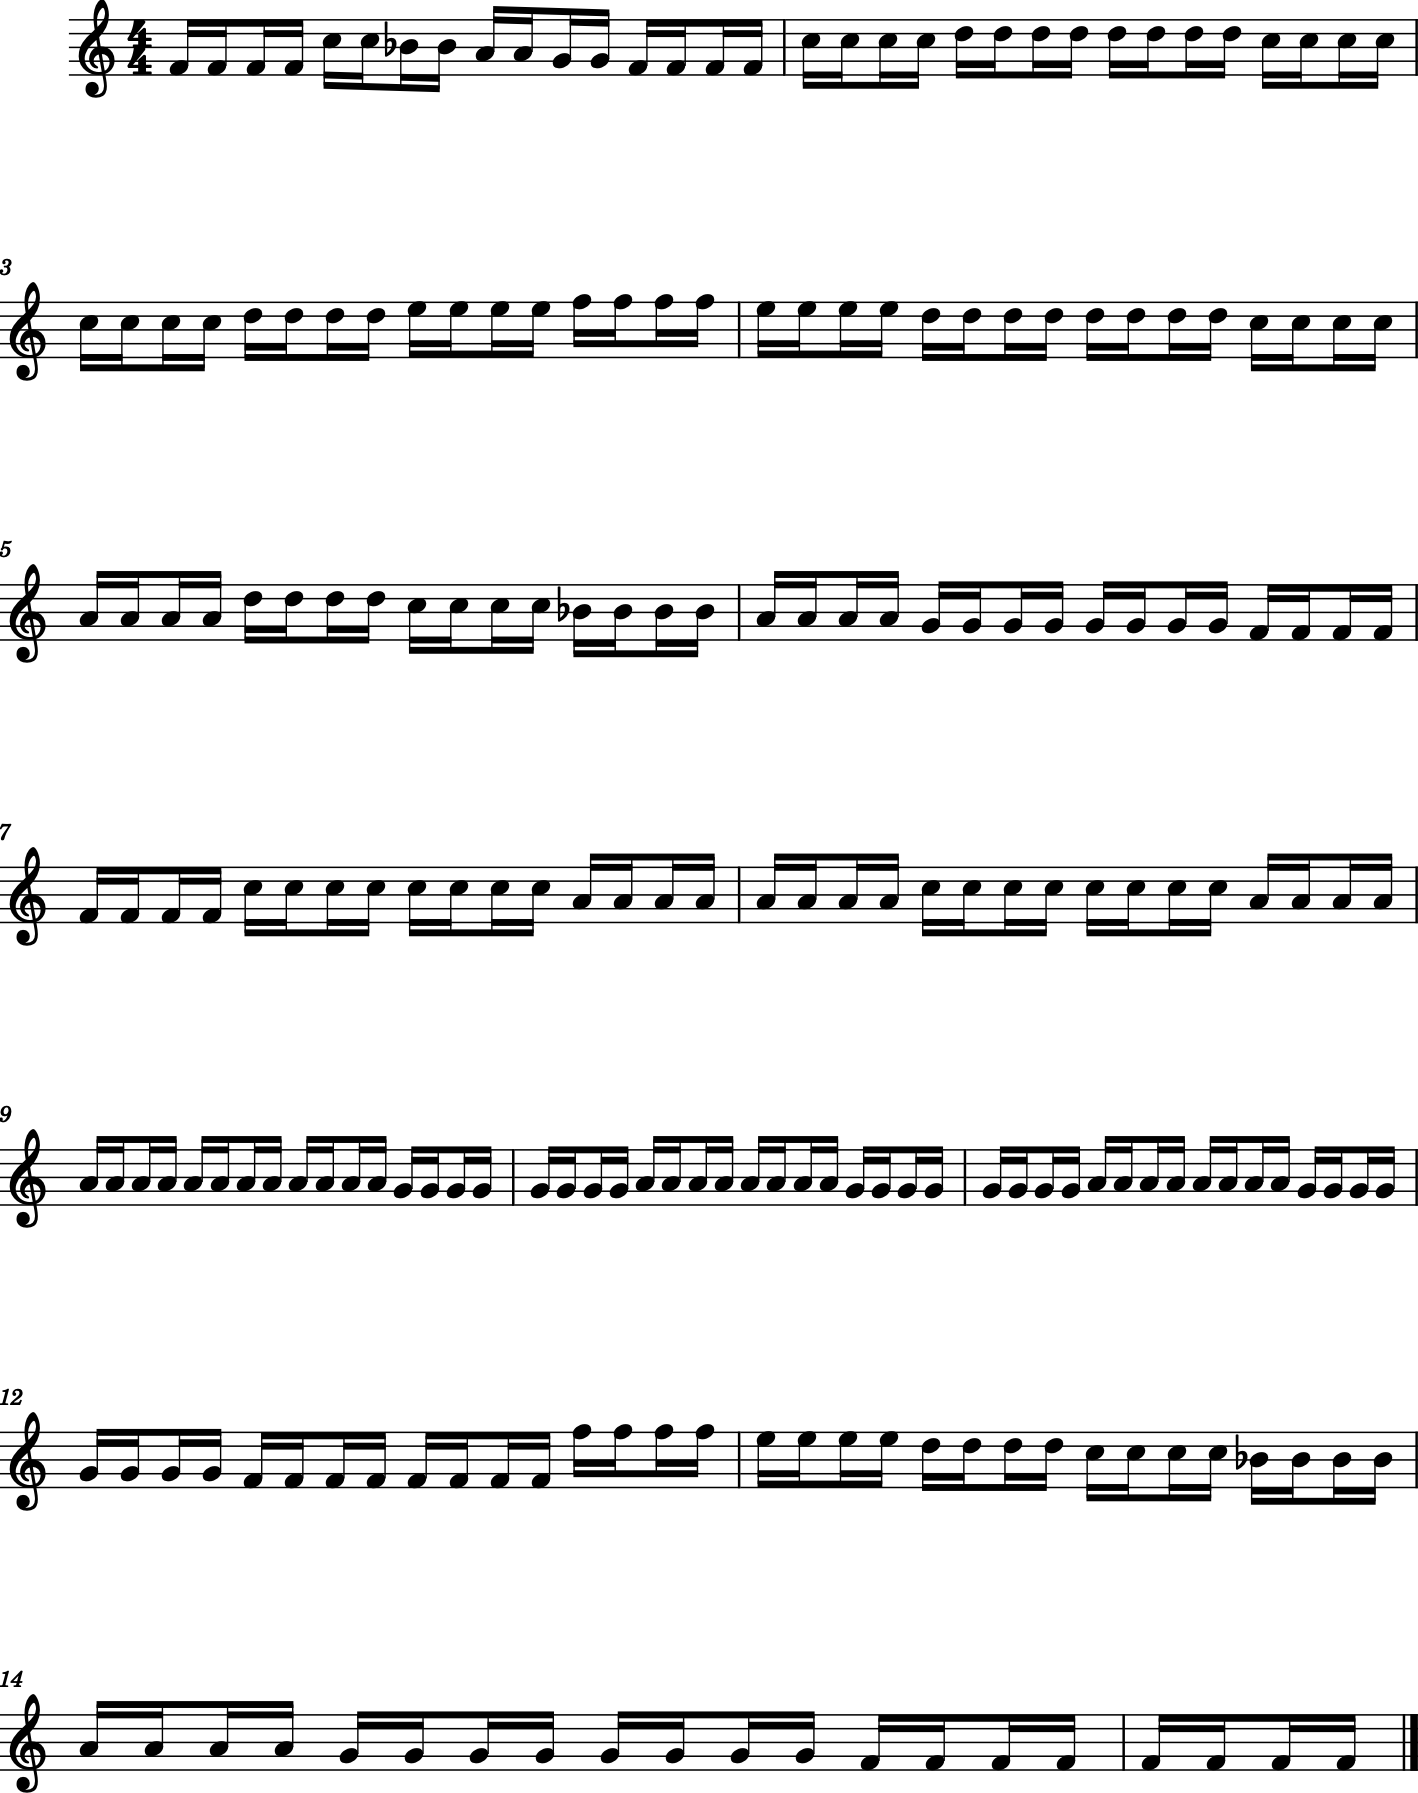

In [54]:
show_midi(decode(data5.data.tolist()), fmt=None)
show_midi(decode(data5.data.tolist()))

The most common notes in the training data:

In [110]:
from collections import Counter

Counter(train_loader5.dataset.dataset.data.tolist()).most_common(10)

[(33, 638),
 (30, 592),
 (28, 533),
 (21, 510),
 (26, 508),
 (29, 504),
 (31, 476),
 (22, 426),
 (38, 401),
 (25, 386)]

In [55]:
torch.manual_seed(1234)
model5 = MelodyLSTM(
    output_size=OUTPUT_SIZE,
    embedding_size=EMBEDDING_SIZE,
    hidden_size=HIDDEN_SIZE,
).to(DEVICE)
loss_fn5 = nn.NLLLoss()  # Input: log probabilities
optimizer5 = optim.Adam(model5.parameters(), lr=1e-3)

In [ ]:
train(
    model=model5,
    train_loader=train_loader5,
    validation_loader=validation_loader5,
    loss_fn=loss_fn5,
    optimizer=optimizer5,
    num_epochs=100,
    device=DEVICE,
)

From the generated sequence below we see the model has learned to make small steps in the melody and to repeat notes 2 or 4 times (not e.g. 3 or 5). 

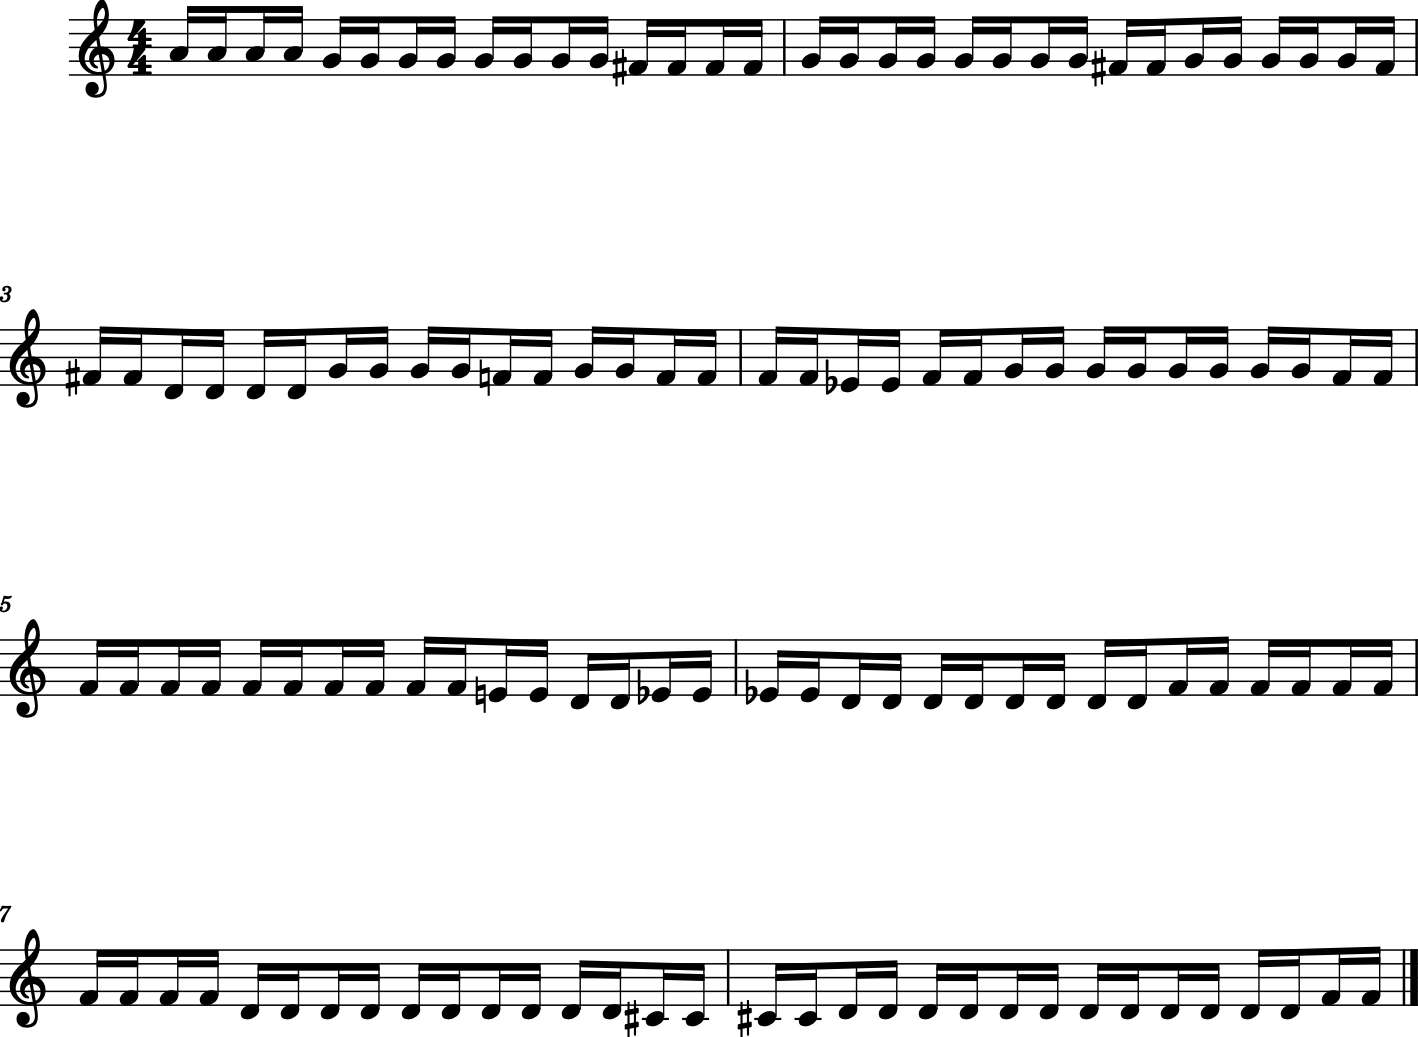

In [222]:
melody = generate_melody(
    model=model5.to("cpu"),
    initial_sequence=[33],
    num_notes=127,
    sequence_length=SEQUENCE_LENGTH,
    temperature=1,
    random_seed=123,
    allowed_notes=list(set(data5.data.tolist())),
)

show_midi(decode(melody), fmt=None)
show_midi(decode(melody), fmt="midi")

# Visualize predictions

Below we plot predictions for all possible first notes. The distribution for the next note are very peaked around the same note, which means that if we give one note to the model, the next generated note will be the same note.

/var/folders/s6/6dqtmwnd33v0v_jdhdk1kk8r0000gn/T/ipykernel_3204/3046335535.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.exp(model([seq])[:, -1].ravel().detach())


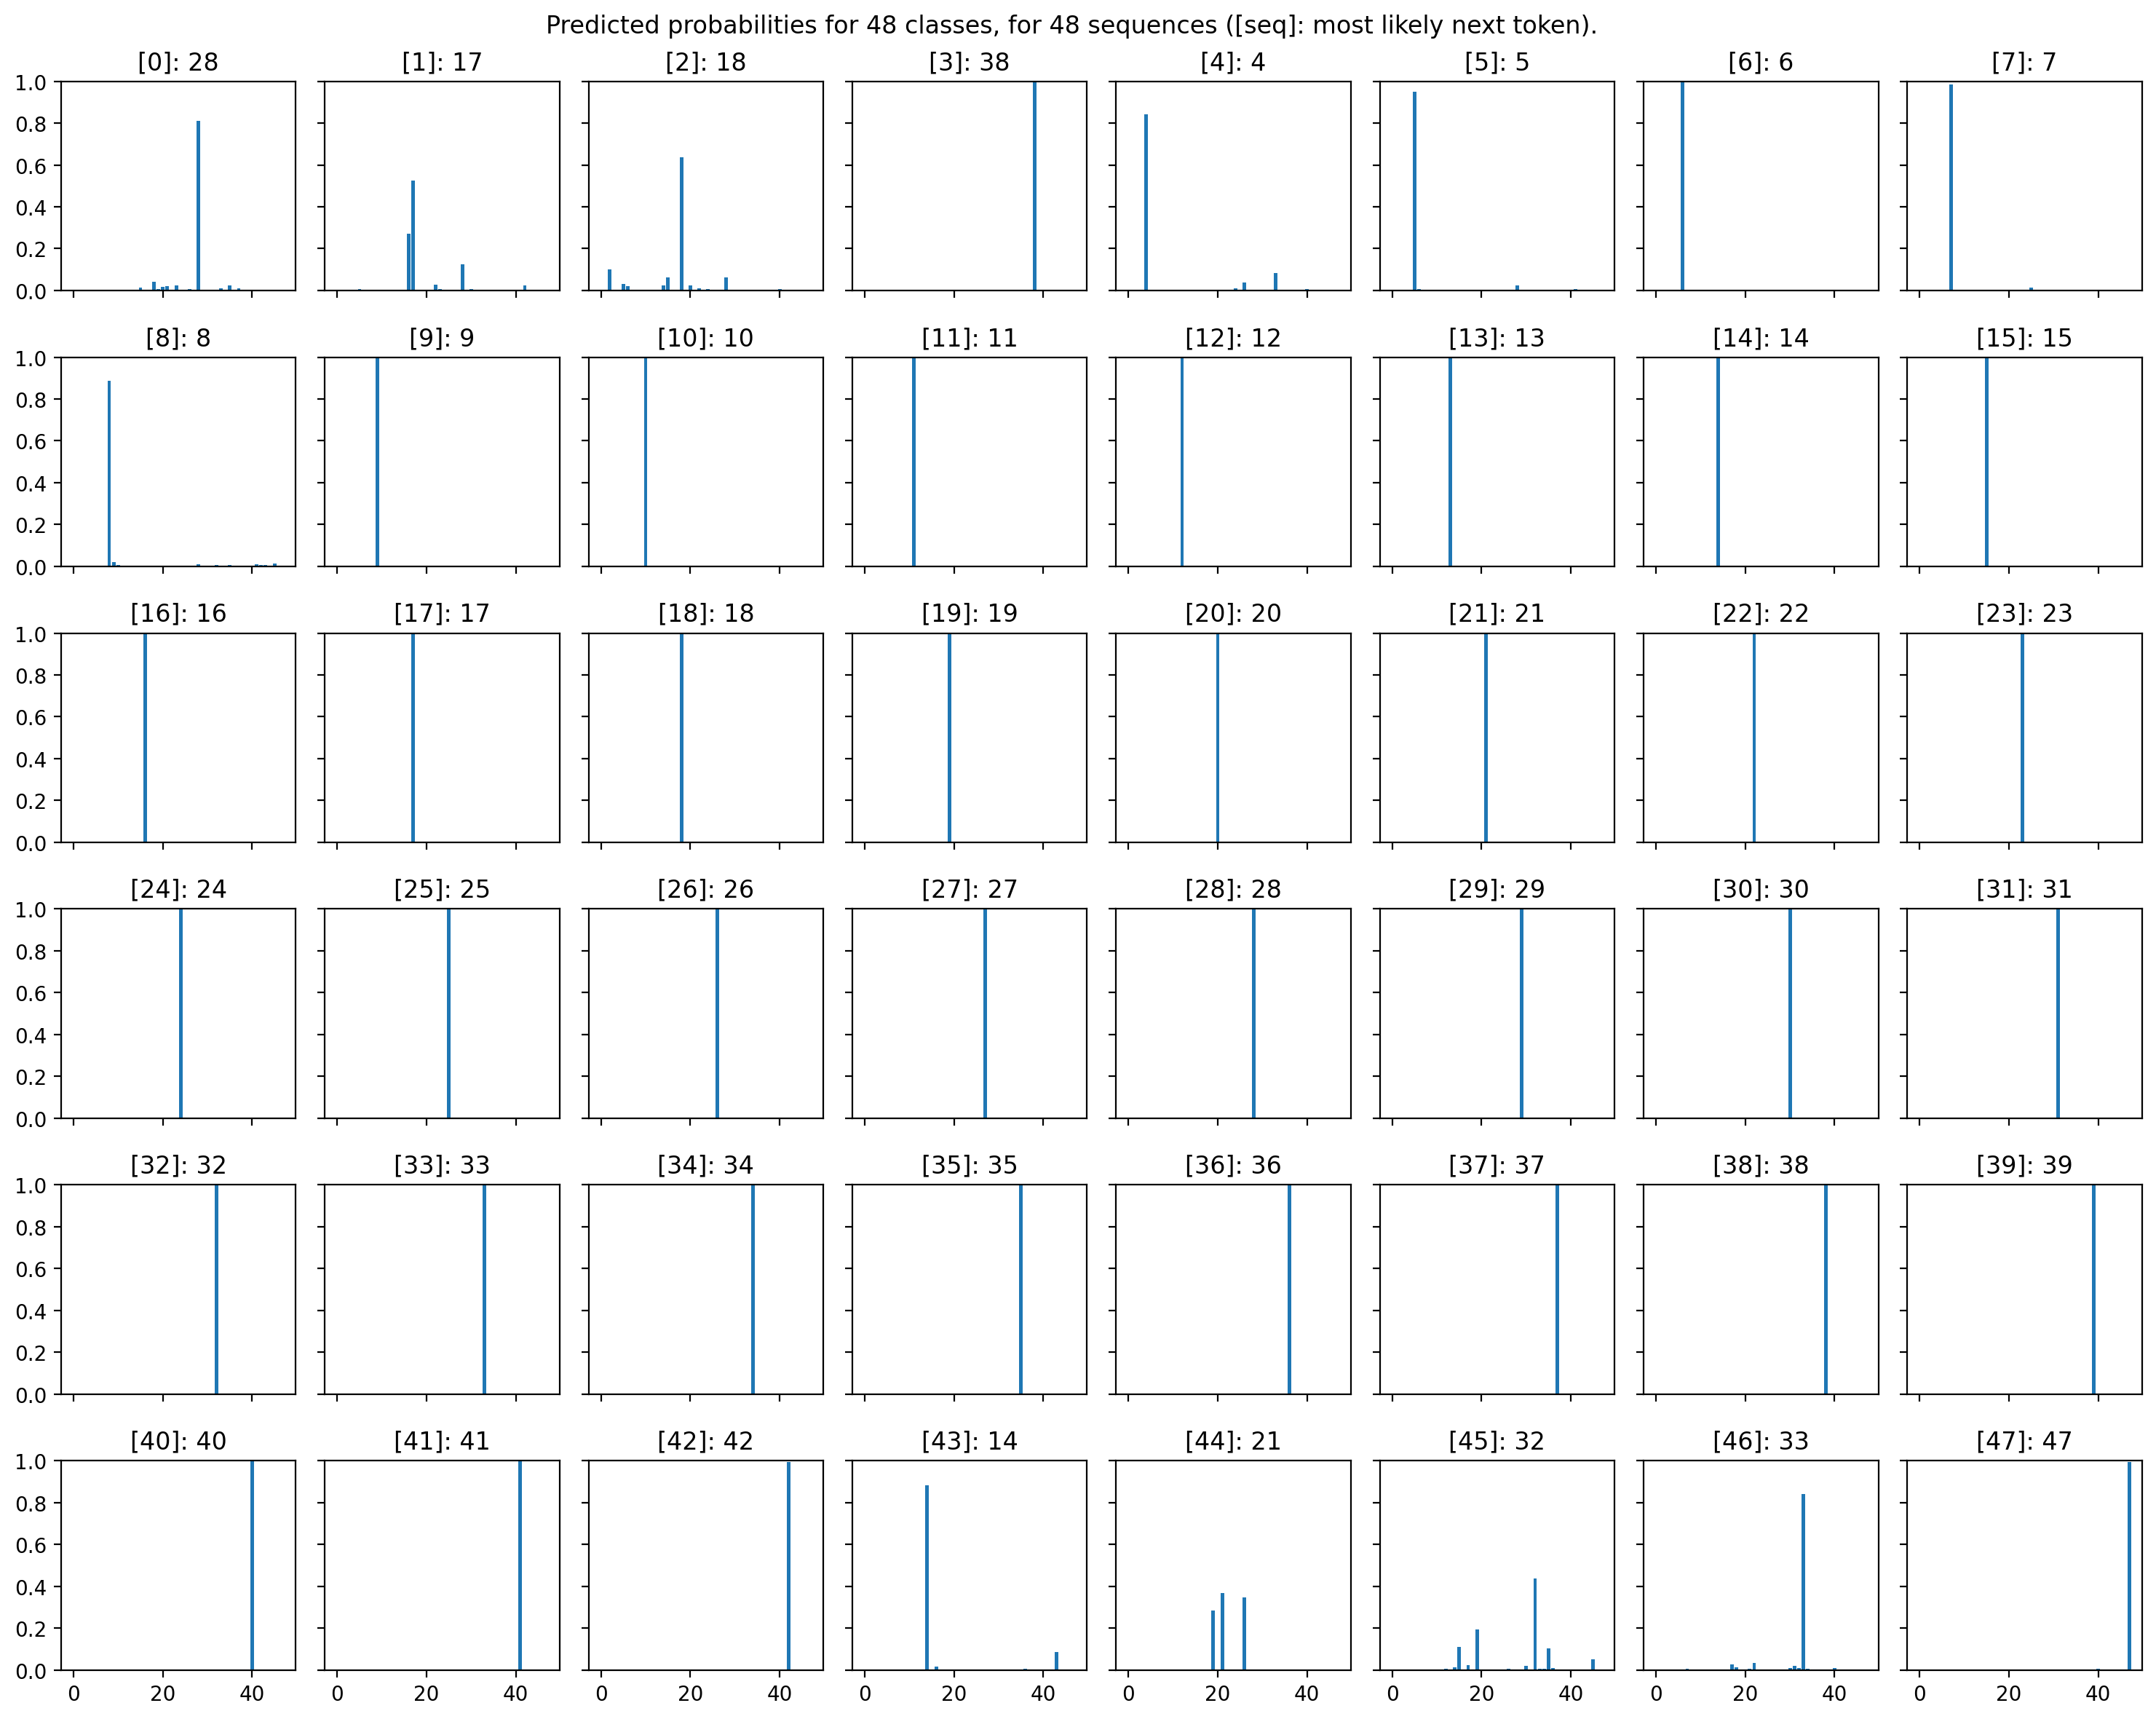

In [227]:
import matplotlib.pyplot as plt


def predict_next_token(seq: list[int], model):
    return np.exp(model([seq])[:, -1].ravel().detach())


def plot_predictions(classes, scores, ax=None, title=""):
    c = plt if ax is None else ax
    c.bar(classes, scores)
    c.set_title(title)


def plot_predictions2(sequences, model, classes=list(encoding.values())):
    fig, axs = plt.subplots(6, 8, figsize=(15, 12), sharey=True, sharex=True)
    axs = axs.flatten()
    for i, seq in enumerate(sequences):
        scores = predict_next_token(seq, model)
        plot_predictions(
            classes,
            scores,
            ax=axs[i],
            title=f"{seq}: {classes[np.argmax(scores)]}",
        )
        axs[i].set_ylim(0, 1)
    plt.suptitle(
        f"Predicted probabilities for {len(classes)} classes, for {len(sequences)} sequences ([seq]: most likely next token)."
    )
    plt.tight_layout()
    plt.show()


plot_predictions2([[v] for v in encoding.values()], model5)

Below are predictions for a longer sequence that has repeated a note several times. The distributions are less peaked so there can be variation in the generated sequences.

/var/folders/s6/6dqtmwnd33v0v_jdhdk1kk8r0000gn/T/ipykernel_3204/2852466354.py:5: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  return np.exp(model([seq])[:, -1].ravel().detach())


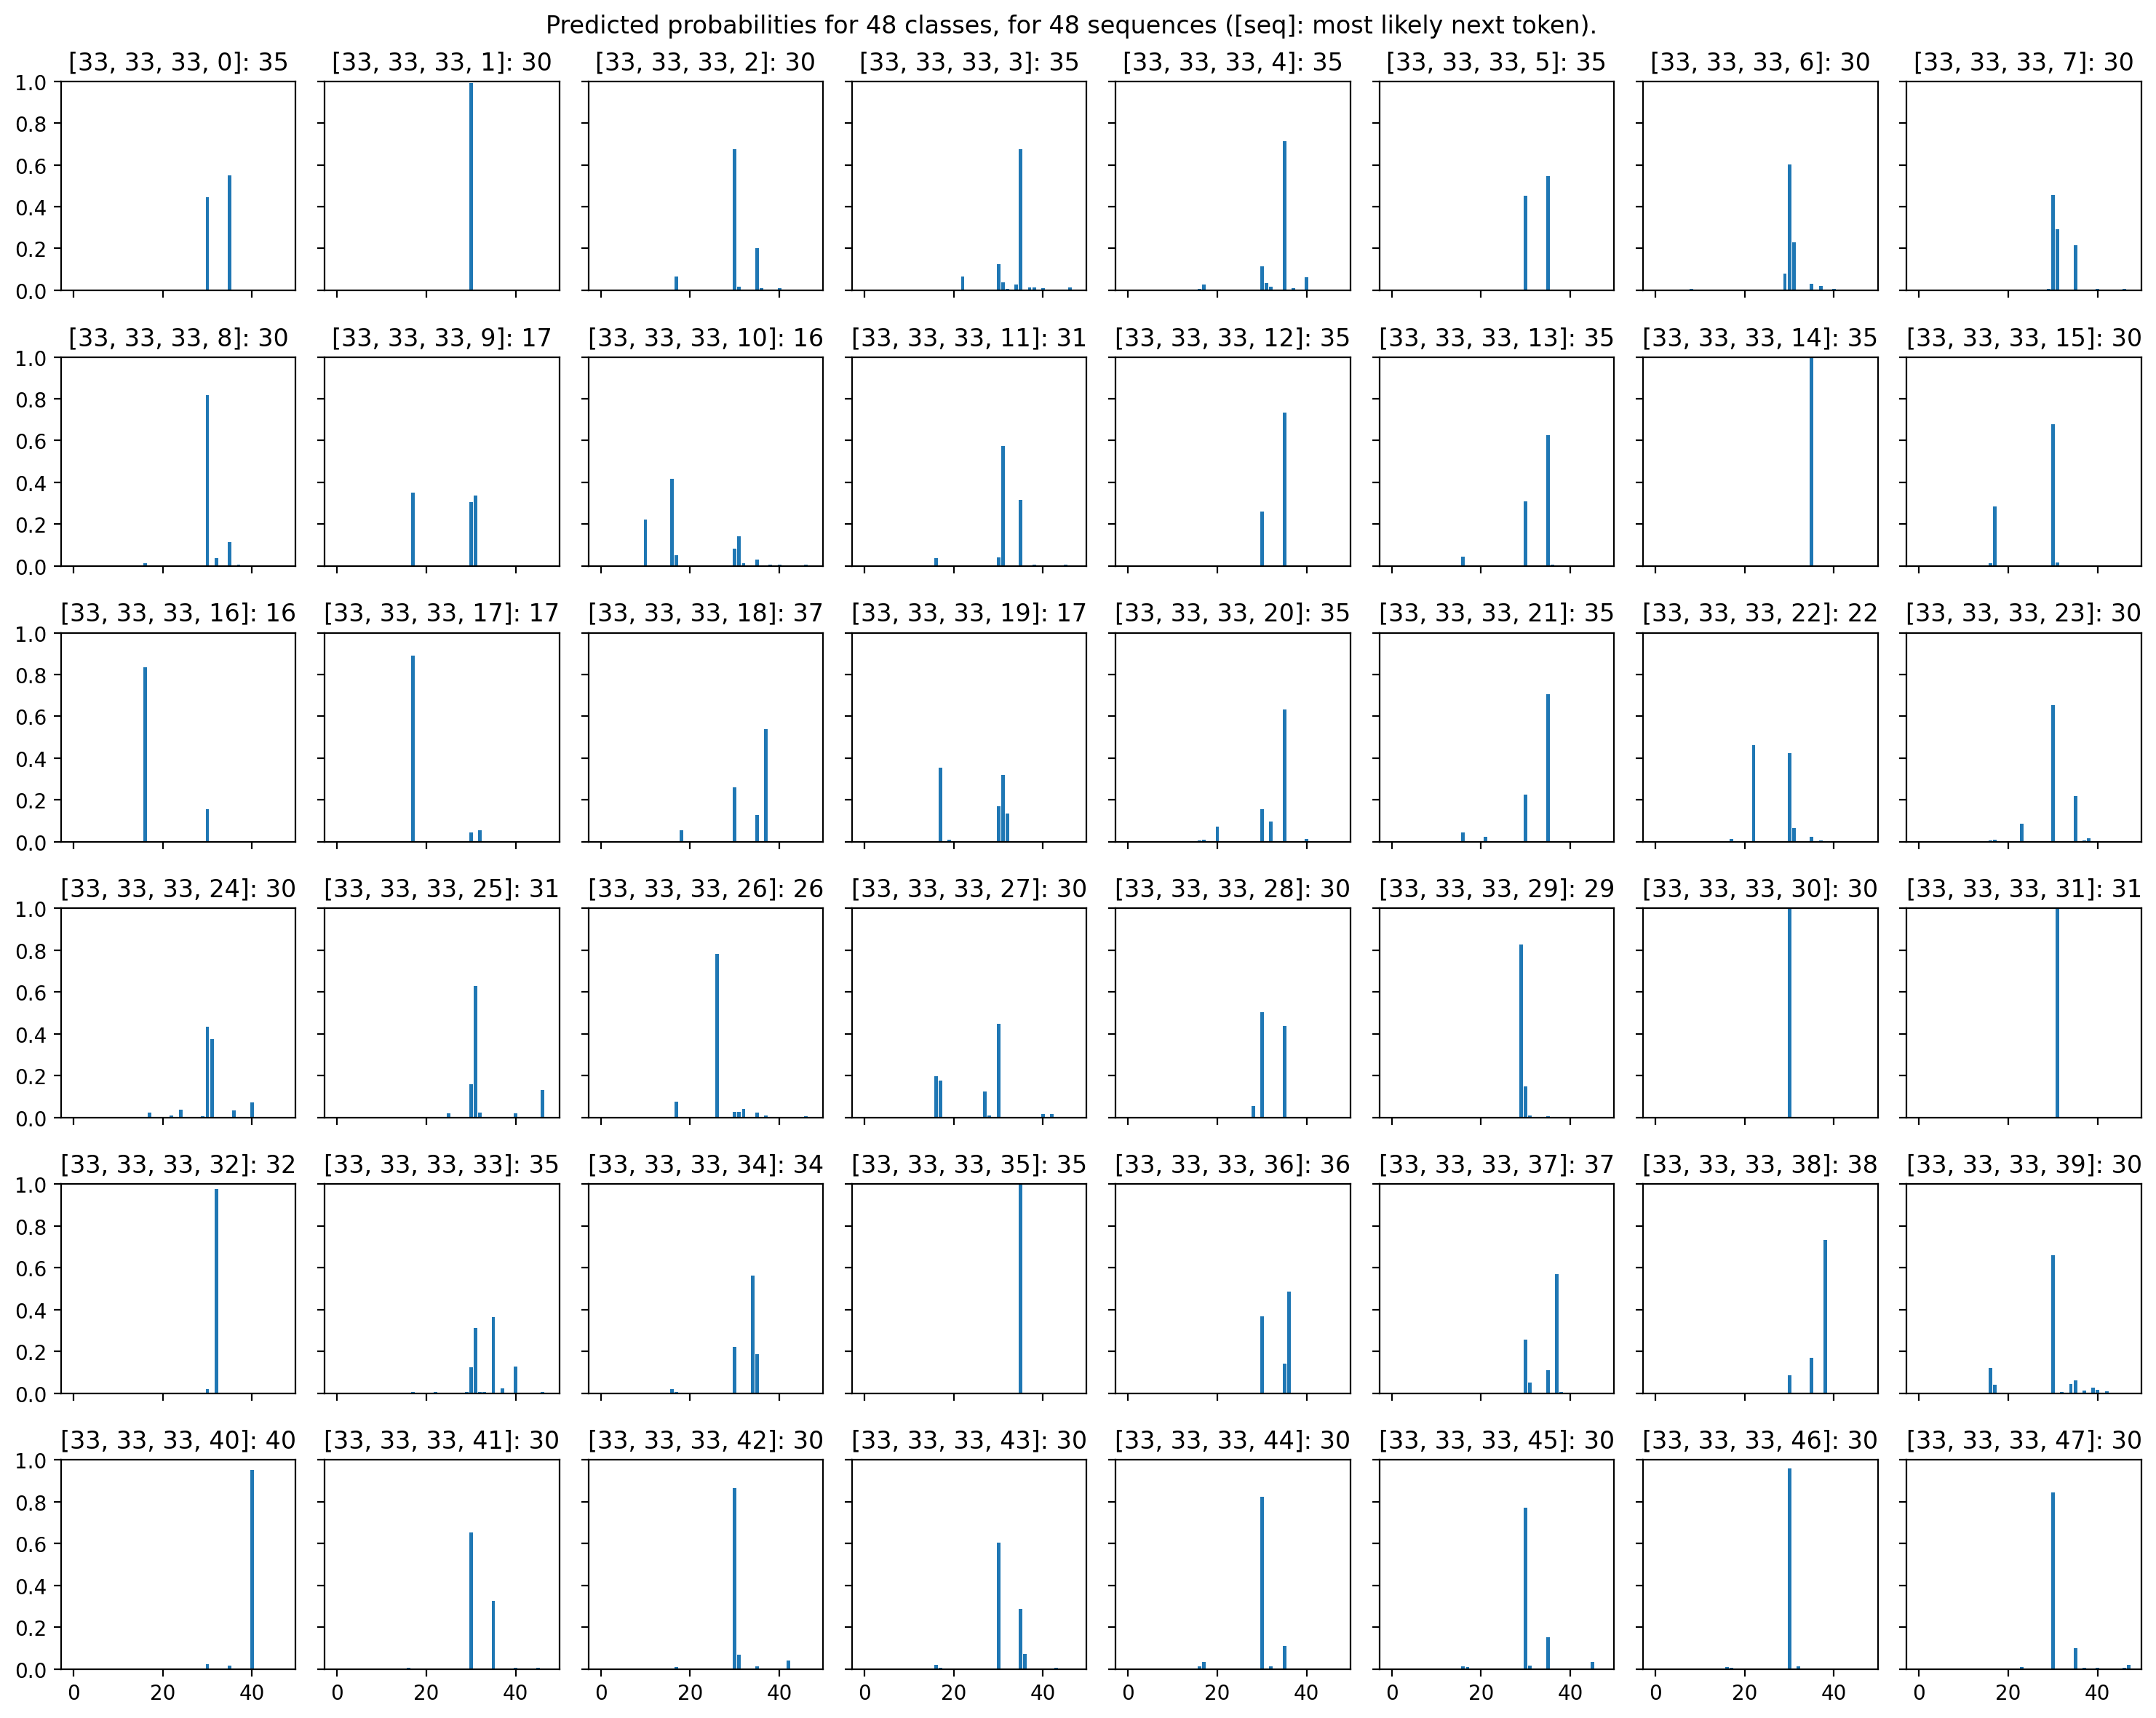

In [192]:
plot_predictions2([[33, 33, 33, v] for v in encoding.values()], model5)